DSCI100/002 Group 5

Decoding Legendary Pokemon 

Introduction:
Pokemon is an entertainment franchise that surrounds a make-believe world where people catch, train and battle animals known as Pokemon. They are created with various statistics, appearances and personalities. In these games we as the player create teams and travel across various regions to battle other trainers and wild Pokemon. All Pokemon have set statistics determining how powerful they are, with the highly desirable “Legendary Pokemon” having much higher statistics than most of the non-legendaries. 
Our predictive question is to determine whether a hypothetical Pokemon we create with random statistics should be considered legendary. We will analyze different selected variables of all the Pokemon up to the sixth generation to determine what constitutes a legendary and put our findings against our new Pokemon to determine if it is legendary or not. For our data, we are using the ‘Pokemon with Stats' dataset from Kaggle, containing the names of pokemon and all of their statistics, and a classification of either legendary or not legendary as variables. (source: https://www.kaggle.com/datasets/abcsds/pokemon)

Methods:
A classification model will be built, using the variables of attack, special attack, defense, special defense, and speed. These variables were chosen because they are the 5 traits that determine the overall strength/quality of a pokemon and there is typically a large difference in these values between legendary-tier pokemon and normal pokemon, so the predictor can be accurate using a nearest k-neighbors classifier. 
One way the results will be visualized is on a box plot, where the y axis is a total sum of all 5 predictor variables together, representing the overall strength of the pokemon. There will be four boxes, one box represents legendary pokemon, one represents non-legendary pokemon. Unknown classes will have 2 different boxes, one for legendary and one for non-legendary based on the prediction of the model. This will allow the reader to see the average stats of the different classes of pokemon, and whether the averages of the predictions match the averages of the known classifications.

In [1]:
#install.packages("themis")

In [2]:
#loading required libraries for the analysis. Install the packages if they are not previously installed.
library(rvest)
library(tidymodels)
library(themis)
library(tidyverse)
set.seed(100)

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ recipes      1.0.6
✔ dials        1.0.0     ✔ rsample      1.0.0
✔ dplyr        1.1.2     ✔ tibble       3.2.1
✔ ggplot2      3.3.6     ✔ tidyr        1.2.0
✔ infer        1.0.2     ✔ tune         1.0.0
✔ modeldata    1.0.0     ✔ workflows    1.0.0
✔ parsnip      1.0.0     ✔ workflowsets 1.0.0
✔ purrr        1.0.1     ✔ yardstick    1.0.0

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ purrr::discard() masks scales::discard()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
✖ recipes::step()  masks stats::step()
• Use tidymodels_prefer() to resolve common conflicts.

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ readr   2.1.2     ✔ forcats 0.5.1
✔ stringr 1.4.0     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ readr::col_factor()     mask

In [16]:
#Reading web data using GitHub generated URL link

url <- "https://raw.githubusercontent.com/dlee03/DSCI_group_project/main/Pokemon.csv" 

pokemon2 <- read_csv(url)
colnames(pokemon2) <- make.names(colnames(pokemon2)) 
head(pokemon2)

Rows: 800 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): Name, Type 1, Type 2
dbl (9): #, Total, HP, Attack, Defense, Sp. Atk, Sp. Def, Speed, Generation
lgl (1): Legendary

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


X.,Name,Type.1,Type.2,Total,HP,Attack,Defense,Sp..Atk,Sp..Def,Speed,Generation,Legendary
<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,FALSE
2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,FALSE
3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,FALSE
3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,FALSE
4,Charmander,Fire,NA,309,39,52,43,60,50,65,1,FALSE
5,Charmeleon,Fire,NA,405,58,64,58,80,65,80,1,FALSE


Table 1. Pokemon dataset that is read from directly from URL. 

In [5]:
#summarize data that reports number of entries per column 

pokemon_selected <- pokemon2 |>
    select(Name, Attack, Defense, Sp..Atk, Sp..Def, Speed, Legendary)
head(pokemon_selected)

Name,Attack,Defense,Sp..Atk,Sp..Def,Speed,Legendary
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
Bulbasaur,49,49,65,65,45,FALSE
Ivysaur,62,63,80,80,60,FALSE
Venusaur,82,83,100,100,80,FALSE
VenusaurMega Venusaur,100,123,122,120,80,FALSE
Charmander,52,43,60,50,65,FALSE
Charmeleon,64,58,80,65,80,FALSE


Table 2. Selected Name, Attack, Defense, Attack Speed, Defense Speed, Speed, and Legendary columns.

In [6]:
#find counts in each
pokemon_counts <- pokemon_selected |> 
    group_by() |>
    summarize(counts = n())
head(pokemon_counts)

counts
<int>
800


pokemon_counts is used to count the number of rows/observations present in the data frame. 

In [7]:
sum(is.na(pokemon_counts)) #check if there is any missing data in the dataframe

[1] 0

In [8]:
#convert the character variable to the factor datatype
pokemon_data <- pokemon_selected |>
    mutate(Legendary = as_factor(Legendary)) 

In [9]:
#make training data set
pokemon_split <- initial_split(pokemon_selected, prop = 0.75, strata = Legendary)
pokemon_train <- training(pokemon_split)
pokemon_test <- testing(pokemon_split)

#convert Legendary column into factor instead of boolean for both training and testing data
pokemon_train <- pokemon_train |>
    mutate(Legendary = as_factor(Legendary)) 
pokemon_test <- pokemon_test |>
    mutate(Legendary = as_factor(Legendary)) 

A training and testing dataset is made, we will be using the training data set to build the model and the testing set to check it's accuracy. We also converted "Legendary" into a factor so we can use statistical functions on this column.  

In [10]:
#table of the mean stats of the training set pokemon, and the number of pokemon used in the training set.
nrow(pokemon_train)
mean_stats_table <- pokemon_train |> 
    summarize(across(Attack:Speed, mean)) |>
    add_column(n_training_pokemon = 600)
mean_stats_table

[1] 600

Attack,Defense,Sp..Atk,Sp..Def,Speed,n_training_pokemon
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
79.845,74.08167,72.98833,70.38167,68.60833,600


Table 3. Summary of statistics using training set pokemon. Using these statistics we can use the model to predict legendary status. 

In [11]:
#create a recipe and model for the analysis

pokemon_recipe <- recipe(Legendary ~ Attack +  Defense + Speed + Sp..Atk + Sp..Def, data = pokemon_train) |>
                    step_scale(all_predictors()) |>
                    step_center(all_predictors()) |>
                    step_upsample(Legendary, over_ratio = 1, skip = TRUE)

pokemon_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                set_engine("kknn") |>
                set_mode("classification")

Recipe, workflow and fit will be used to train the classifier.

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9333333,10,0.013608276,Preprocessor1_Model01
2,accuracy,binary,0.9316667,10,0.013252067,Preprocessor1_Model02
3,accuracy,binary,0.9216667,10,0.007876359,Preprocessor1_Model03
4,accuracy,binary,0.9200000,10,0.009875772,Preprocessor1_Model04
5,accuracy,binary,0.9116667,10,0.004339028,Preprocessor1_Model05
6,accuracy,binary,0.9100000,10,0.005091751,Preprocessor1_Model06


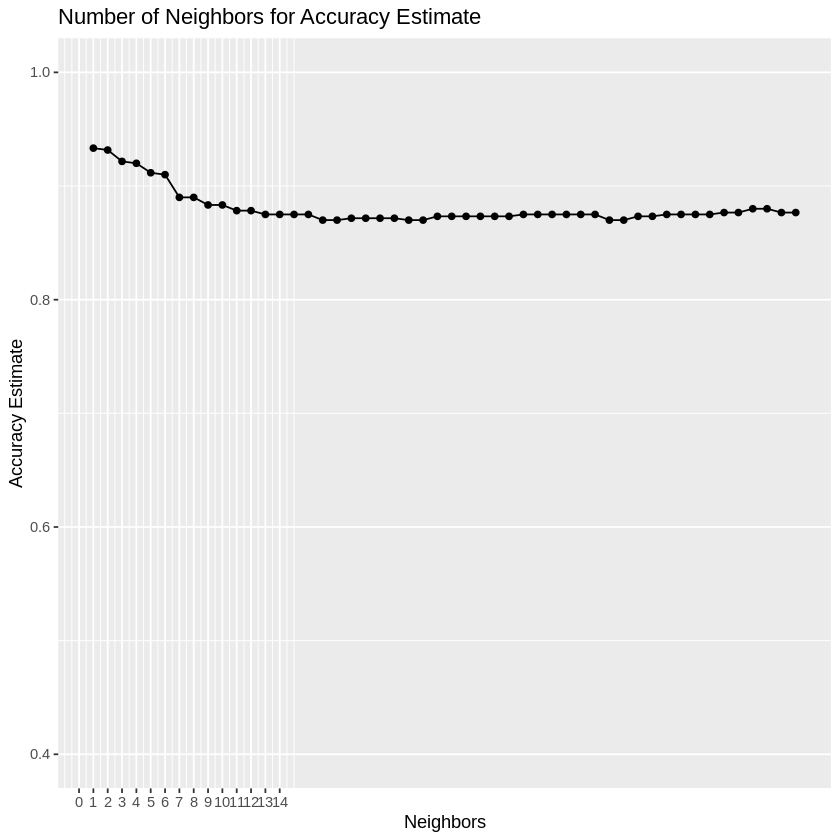

In [21]:
#cross-validate and tune the model using a 10-fold cross-validation
pokemon_vfold <- vfold_cv(pokemon_train, v = 10, strata = Legendary)

kvals <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

pokemon_k_test <- workflow() |>
    add_recipe(pokemon_recipe) |>
    add_model(pokemon_spec) |>
    tune_grid(resamples = pokemon_vfold, grid = kvals) |>
    collect_metrics()

accuracies <- pokemon_k_test |>
    filter(.metric == "accuracy")
head(accuracies)

k_val_plot <-  ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       ggtitle ("Number of Neighbors for Accuracy Estimate")+
       scale_x_continuous(breaks = seq(0, 14, by = 1)) +  
       scale_y_continuous(limits = c(0.4, 1.0)) 
k_val_plot

Table 4. Accuracies of training set data.

Figure 1. Accuracy Estimate vs. K-Nearest Neighbours. Here we are using K=5 because it there is a smaller slope (decrease of accuracy) between points 4 and 5 than 5 and 6. This indicates that using K =5 will offer the least clusters for the highest accuracy. 

In [24]:
#create a new model with k = 5
pokemon_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
                set_engine("kknn") |>
                set_mode("classification")

pokemon_fit <- workflow() |>
    add_recipe(pokemon_recipe) |>
    add_model(pokemon_spec) |>
    fit(data = pokemon_train)
pokemon_fit

Warning message:
“tune samples were requested but there were 1100 rows in the data. 1095 will be used.”


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
3 Recipe Steps

• step_scale()
• step_center()
• step_upsample()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(tune(),     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.38
Best kernel: rectangular
Best k: 1095

Recipe, workflow and fit will be used again to train the classifier using the training dataset.

In [15]:
pokemon_predictions <- predict(pokemon_fit, pokemon_train) |>
                     bind_cols(pokemon_train) 
head(pokemon_predictions)    

pokemon_metrics <- pokemon_predictions |>
                 metrics(truth = Legendary, estimate = .pred_class) |>
                 filter(.metric == "accuracy")
pokemon_metrics

pokemon_conf_mat <- pokemon_predictions |>
                  conf_mat(truth = Legendary, estimate = .pred_class)

pokemon_conf_mat

.pred_class,Name,Attack,Defense,Sp..Atk,Sp..Def,Speed,Legendary
<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
FALSE,Bulbasaur,49,49,65,65,45,FALSE
FALSE,Ivysaur,62,63,80,80,60,FALSE
FALSE,VenusaurMega Venusaur,100,123,122,120,80,FALSE
FALSE,Charmeleon,64,58,80,65,80,FALSE
TRUE,Charizard,84,78,109,85,100,FALSE
TRUE,CharizardMega Charizard Y,104,78,159,115,100,FALSE


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8066667


          Truth
Prediction FALSE TRUE
     FALSE   447   13
     TRUE    103   37

Table 5. Prediction of pokemon class (legendary vs. non legendary). 

Table 6. Accuracy of training dataset is tested and a matrix is created. Here 484 (447 + 37) predicted correctly and 116 (103 + 13) predicted incorrectly. This gives us an accuracy of 80.66% for our model. 

Discussion: 


In [ ]:
Citations:
